/tmp/ipykernel_6644/2032043972.py:109: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(val, 1, marker=marker, s=size, color=col, zorder=10,


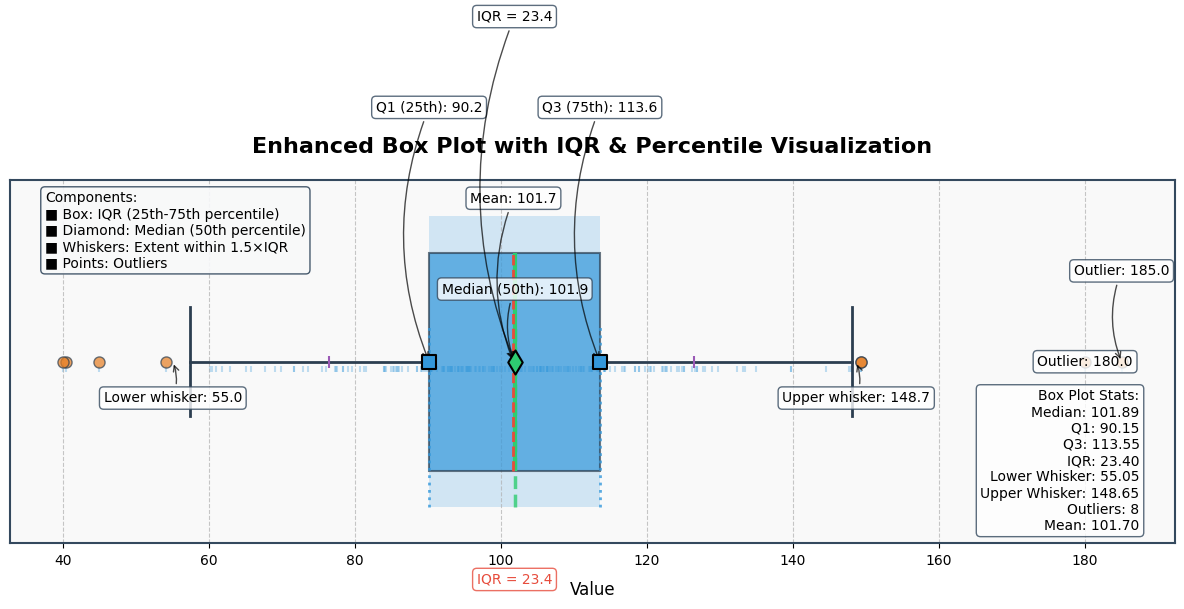

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def get_statistics(data):
    """Compute key statistics for the boxplot."""
    median = np.median(data)
    mean = np.mean(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = max(np.min(data), q1 - 1.5 * iqr)
    upper_whisker = min(np.max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]
    return median, mean, q1, q3, iqr, lower_whisker, upper_whisker, outliers

def style_boxplot(ax, bp, colors):
    """Apply custom styling to the boxplot elements."""
    # Style the box
    for patch, color in zip(bp['boxes'], colors['box']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor(colors['whisker'])
        patch.set_linewidth(1.5)
        
    # Style whiskers and caps
    for element in ['whiskers', 'caps']:
        for line in bp[element]:
            line.set_color(colors['whisker'])
            line.set_linewidth(2)
    
    # Style median, mean, and outliers (fliers)
    for line in bp['medians']:
        line.set_color(colors['median'])
        line.set_linewidth(3)
    
    for line in bp['means']:
        line.set_color(colors['mean'])
        line.set_linewidth(2)
        line.set_linestyle('--')
    
    for flier in bp['fliers']:
        flier.set_markerfacecolor(colors['flier'])
        flier.set_markeredgecolor(colors['whisker'])
        flier.set_markersize(8)
        flier.set_alpha(0.7)

def add_annotation(ax, annotation_positions, x_pos, text, base_y=1.2, y_offset=0, arrow=True):
    """Place an annotation smartly to avoid overlapping."""
    spacing = 0.25
    # Find nearby annotation positions to adjust the new annotation's vertical position
    nearby = [y for xpos, y in annotation_positions.items() if abs(xpos - x_pos) < 15]
    y_pos = (max(nearby) + spacing) if nearby else (base_y + y_offset)
    annotation_positions[x_pos] = y_pos
    
    if arrow:
        ax.annotate(text,
                    xy=(x_pos, 1),
                    xytext=(x_pos, y_pos),
                    arrowprops=dict(facecolor='#34495e', arrowstyle="->",
                                    connectionstyle="arc3,rad=.2", alpha=0.7),
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                              edgecolor='#34495e', alpha=0.8))
    else:
        ax.text(x_pos, y_pos, text,
                ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                          edgecolor='#34495e', alpha=0.8))

def plot_enhanced_boxplot(data):
    # Calculate statistics
    median, mean, q1, q3, iqr, lower_whisker, upper_whisker, outliers = get_statistics(data)
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
    ax.set_facecolor('#f9f9f9')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Create the boxplot with custom settings
    bp = ax.boxplot(data, vert=False, patch_artist=True, showmeans=True, meanline=True, widths=0.6)
    
    # Define a custom color palette
    colors = {
        'box': ['#3498db'],      # Soft blue for the box
        'whisker': '#2c3e50',     # Dark blue-gray for whiskers and caps
        'mean': '#e74c3c',        # Soft red for the mean
        'median': '#2ecc71',      # Soft green for the median
        'flier': '#e67e22'        # Soft orange for outliers
    }
    style_boxplot(ax, bp, colors)
    
    # Add shading to highlight the IQR area
    box_coords = bp['boxes'][0].get_path().vertices
    x_vals = box_coords[:, 0]
    iqr_min, iqr_max = min(x_vals), max(x_vals)
    iqr_rect = Rectangle((iqr_min, 0.6), iqr_max - iqr_min, 0.8,
                         facecolor='#3498db', alpha=0.2, zorder=0)
    ax.add_patch(iqr_rect)
    
    # Add percentile markers along the boxplot
    percentiles = [10, 25, 50, 75, 90]
    percentile_vals = [np.percentile(data, p) for p in percentiles]
    perc_colors = ['#9b59b6', '#3498db', '#2ecc71', '#3498db', '#9b59b6']
    marker_styles = ['|', 's', 'd', 's', '|']
    marker_sizes = [80, 100, 150, 100, 80]
    
    for p, val, col, marker, size in zip(percentiles, percentile_vals, perc_colors, marker_styles, marker_sizes):
        ax.scatter(val, 1, marker=marker, s=size, color=col, zorder=10,
                   edgecolor='black', linewidth=1.5)
    
    # Annotation dictionary to track placement and avoid overlaps
    annotation_positions = {}
    # Add annotations for key statistics
    add_annotation(ax, annotation_positions, median, f'Median (50th): {median:.1f}')
    add_annotation(ax, annotation_positions, mean, f'Mean: {mean:.1f}', y_offset=0.2)
    add_annotation(ax, annotation_positions, q1, f'Q1 (25th): {q1:.1f}', y_offset=-0.1)
    add_annotation(ax, annotation_positions, q3, f'Q3 (75th): {q3:.1f}', y_offset=-0.1)
    add_annotation(ax, annotation_positions, (q1 + q3) / 2, f'IQR = {iqr:.1f}', y_offset=0.3)
    add_annotation(ax, annotation_positions, lower_whisker, f'Lower whisker: {lower_whisker:.1f}', y_offset=-0.3)
    add_annotation(ax, annotation_positions, upper_whisker, f'Upper whisker: {upper_whisker:.1f}', y_offset=-0.3)
    
    # Annotate significant outliers (limit to three to keep the plot clear)
    significant_outliers = [o for o in outliers if o < lower_whisker - iqr or o > upper_whisker + iqr]
    for outlier in significant_outliers[:3]:
        add_annotation(ax, annotation_positions, outlier, f'Outlier: {outlier:.1f}', y_offset=-0.2)
    
    # Add a summary text box with the key statistics
    stats_text = (
        f"Box Plot Stats:\n"
        f"Median: {median:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}\n"
        f"Lower Whisker: {lower_whisker:.2f}\n"
        f"Upper Whisker: {upper_whisker:.2f}\n"
        f"Outliers: {len(outliers)}\n"
        f"Mean: {mean:.2f}"
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#34495e')
    ax.text(0.97, 0.03, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # Title and axis labels
    ax.set_title('Enhanced Box Plot with IQR & Percentile Visualization', fontsize=16, pad=20, fontweight='bold')
    ax.set_xlabel('Value', fontsize=12, labelpad=10)
    ax.set_yticks([])  # Remove y-axis ticks for horizontal boxplot
    
    # Explanatory text about plot components
    comp_text = (
        "Components:\n"
        "■ Box: IQR (25th-75th percentile)\n"
        "■ Diamond: Median (50th percentile)\n"
        "■ Whiskers: Extent within 1.5×IQR\n"
        "■ Points: Outliers"
    )
    props = dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.9, edgecolor='#34495e')
    ax.text(0.03, 0.97, comp_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props)
    
    # Enhance border styling
    for spine in ax.spines.values():
        spine.set_edgecolor('#34495e')
        spine.set_linewidth(1.5)
    
    # Add markers to indicate the distribution of data along the axis
    ax.scatter(data, [0.98] * len(data), s=15, c='#3498db', alpha=0.3, marker='|')
    
    # Draw vertical lines for key percentiles (Q1, Median, Q3)
    perc_lines = [q1, median, q3]
    line_styles = [':', '--', ':']
    line_colors = ['#3498db', '#2ecc71', '#3498db']
    line_widths = [2, 2.5, 2]
    for val, style, color, width in zip(perc_lines, line_styles, line_colors, line_widths):
        ax.axvline(x=val, ymin=0.1, ymax=0.6, color=color, linestyle=style,
                   linewidth=width, alpha=0.8)
    
    # Add an arrow between Q1 and Q3 with IQR value
    iqr_mid = (q1 + q3) / 2
    ax.annotate('', xy=(q1, 0.45), xytext=(q3, 0.45),
                arrowprops=dict(arrowstyle='<->', color='#e74c3c', lw=2))
    ax.text(iqr_mid, 0.42, f'IQR = {iqr:.1f}', ha='center', va='top', color='#e74c3c',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                      alpha=0.8, edgecolor='#e74c3c'))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Generate random data and add a few deliberate outliers
    np.random.seed(10)
    data = np.random.normal(100, 20, 200)
    data = np.append(data, [40, 45, 180, 185])
    
    plot_enhanced_boxplot(data)
